[INIT] Import thư viện hoàn tất

[PART 1] Mount Google Drive & cấu hình đường dẫn
Mounted at /content/drive
BASE_DIR      : /content/drive/MyDrive/Speech_Emotion_Recognition_1
RAVDESS_DIR   : /content/drive/MyDrive/Speech_Emotion_Recognition_1/input/ravdess-emotional-speech-audio
TESS_DIR      : /content/drive/MyDrive/Speech_Emotion_Recognition_1/input/TESS Toronto emotional speech set data
PROCESSED_DIR : /content/drive/MyDrive/Speech_Emotion_Recognition_1/working/processed

[PART 2] Khai báo nhãn cảm xúc
Số nhãn: 7

[PART 4] Quét toàn bộ file audio
RAVDESS files quét: 1440
TESS files quét   : 2800
Tổng số mẫu hợp lệ: 4240
Phân bố nhãn:
label_id
0    688
1    592
2    592
3    592
4    592
5    592
6    592
Name: count, dtype: int64

[PART 5] Chia tập dữ liệu
Train (trước balance): 2883
Validation           : 509
Test                 : 848

[PART 6] Oversampling dữ liệu train
Train size sau balance: 3269
Phân bố nhãn sau balance:
label_id
0    467
1    467
2    467
3    467
4    467
5

100%|██████████| 848/848 [00:17<00:00, 47.48it/s]


Feature shapes: Train: (13076, 162) Val: (509, 162) Test: (848, 162)

[PART 11] Chuẩn hóa & lưu feature
Đã lưu toàn bộ .npy

[PART 12] Huấn luyện & đánh giá SVM

Train Accuracy: 0.9693331293973693
[[1853    1    4    0    4    6    0]
 [  20 1812    8    4   10    5    9]
 [  92    9 1741    0    6   17    3]
 [   7    6    2 1821    2   25    5]
 [  18    7    7    2 1816   11    7]
 [  25    4    8    7    2 1807   15]
 [  16    7    1    4    5   10 1825]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1868
           1       0.98      0.97      0.98      1868
           2       0.98      0.93      0.96      1868
           3       0.99      0.97      0.98      1868
           4       0.98      0.97      0.98      1868
           5       0.96      0.97      0.96      1868
           6       0.98      0.98      0.98      1868

    accuracy                           0.97     13076
   macro avg       0.97      0.97      0.97     

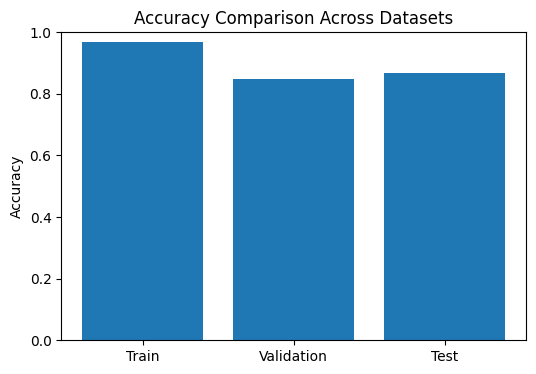

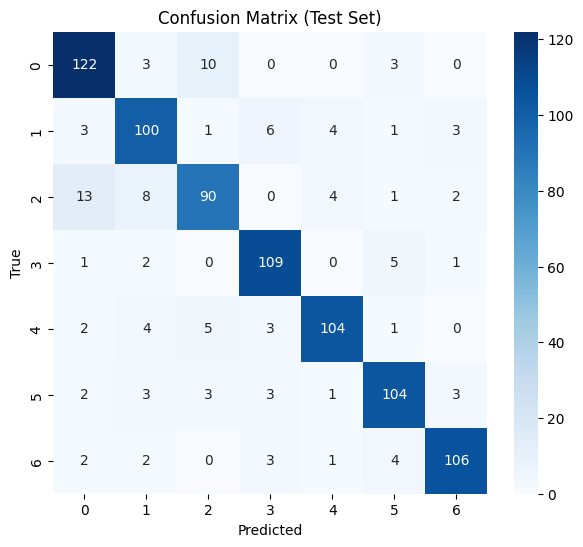

In [1]:
# ============================================================
# SPEECH EMOTION RECOGNITION - FULL DATA PIPELINE
# ============================================================

# ============================================================
# PART 0. IMPORT
# ============================================================
import os
import random
import librosa
import soundfile as sf
import numpy as np
import pandas as pd

from tqdm import tqdm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("=" * 70)
print("[INIT] Import thư viện hoàn tất")


# ============================================================
# PART 1. PATH CONFIG
# ============================================================
print("\n[PART 1] Mount Google Drive & cấu hình đường dẫn")

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/Speech_Emotion_Recognition_1"
INPUT_DIR = os.path.join(BASE_DIR, "input")
RAVDESS_DIR = os.path.join(INPUT_DIR, "ravdess-emotional-speech-audio")
TESS_DIR = os.path.join(INPUT_DIR, "TESS Toronto emotional speech set data")
PROCESSED_DIR = os.path.join(BASE_DIR, "working/processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

print("BASE_DIR      :", BASE_DIR)
print("RAVDESS_DIR   :", RAVDESS_DIR)
print("TESS_DIR      :", TESS_DIR)
print("PROCESSED_DIR :", PROCESSED_DIR)


# ============================================================
# PART 2. LABEL MAPPING
# ============================================================
print("\n[PART 2] Khai báo nhãn cảm xúc")

RAVDESS_MAP = {
    '01': 'neutral', '02': 'neutral',
    '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful',
    '07': 'disgust', '08': 'surprised'
}

TESS_MAP = {
    'neutral': 'neutral',
    'happy': 'happy',
    'sad': 'sad',
    'angry': 'angry',
    'fear': 'fearful',
    'disgust': 'disgust',
    'ps': 'surprised'
}

EMOTION_TO_ID = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'angry': 3,
    'fearful': 4,
    'disgust': 5,
    'surprised': 6
}

print("Số nhãn:", len(EMOTION_TO_ID))


# ============================================================
# PART 3. AUDIO PREPROCESS
# ============================================================
def preprocess_audio(path, target_sr=16000):
    try:
        y, sr = librosa.load(path, sr=None)
        if y.ndim > 1:
            y = librosa.to_mono(y)
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        return y, target_sr
    except Exception as e:
        return None, None


# ============================================================
# PART 4. SCAN DATASET
# ============================================================
print("\n[PART 4] Quét toàn bộ file audio")

all_data = []
rav_count, tess_count = 0, 0

for root, _, files in os.walk(RAVDESS_DIR):
    for f in files:
        if f.endswith(".wav"):
            rav_count += 1
            parts = f.split('-')
            if len(parts) >= 3:
                emo = RAVDESS_MAP.get(parts[2])
                if emo:
                    all_data.append({
                        "raw_path": os.path.join(root, f),
                        "label_id": EMOTION_TO_ID[emo]
                    })

for root, _, files in os.walk(TESS_DIR):
    for f in files:
        if f.endswith(".wav"):
            tess_count += 1
            emo_key = f.lower().split('.')[0].split('_')[-1]
            emo = TESS_MAP.get(emo_key)
            if emo:
                all_data.append({
                    "raw_path": os.path.join(root, f),
                    "label_id": EMOTION_TO_ID[emo]
                })

df_raw = pd.DataFrame(all_data)

print(f"RAVDESS files quét: {rav_count}")
print(f"TESS files quét   : {tess_count}")
print(f"Tổng số mẫu hợp lệ: {len(df_raw)}")
print("Phân bố nhãn:")
print(df_raw['label_id'].value_counts().sort_index())


# ============================================================
# PART 5. SPLIT TRAIN / VAL / TEST
# ============================================================
print("\n[PART 5] Chia tập dữ liệu")

df_train_full, df_test = train_test_split(
    df_raw, test_size=0.2,
    stratify=df_raw['label_id'],
    random_state=42
)

df_train, df_val = train_test_split(
    df_train_full, test_size=0.15,
    stratify=df_train_full['label_id'],
    random_state=42
)

print("Train (trước balance):", len(df_train))
print("Validation           :", len(df_val))
print("Test                 :", len(df_test))


# ============================================================
# PART 6. OVERSAMPLING TRAIN
# ============================================================
print("\n[PART 6] Oversampling dữ liệu train")

max_size = df_train['label_id'].value_counts().max()
balanced = []

for label in sorted(df_train['label_id'].unique()):
    df_cls = df_train[df_train['label_id'] == label]
    df_cls = resample(df_cls, replace=True, n_samples=max_size, random_state=42)
    balanced.append(df_cls)

df_train = pd.concat(balanced)

print("Train size sau balance:", len(df_train))
print("Phân bố nhãn sau balance:")
print(df_train['label_id'].value_counts().sort_index())


# ============================================================
# PART 7. SAVE PROCESSED AUDIO
# ============================================================
def save_processed_audio(df, folder):
    save_dir = os.path.join(PROCESSED_DIR, folder)
    os.makedirs(save_dir, exist_ok=True)

    path_map = {}
    for i, raw_path in enumerate(df['raw_path'].unique()):
        y, sr = preprocess_audio(raw_path)
        if y is None:
            continue
        new_name = f"{folder}_{i}.wav"
        sf.write(os.path.join(save_dir, new_name), y, sr)
        path_map[raw_path] = os.path.join(folder, new_name)

    df['file_path'] = df['raw_path'].map(path_map)
    return df.dropna(subset=['file_path'])


print("\n[PART 7] Lưu audio đã chuẩn hóa")

df_train = save_processed_audio(df_train, "train")
df_val   = save_processed_audio(df_val, "val")
df_test  = save_processed_audio(df_test, "test")

print("Audio saved:",
      "Train:", len(df_train),
      "Val:", len(df_val),
      "Test:", len(df_test))


# ============================================================
# PART 8. DATA AUGMENTATION (CHỈ DÙNG CHO TRAIN)
# ============================================================

def fix_length(y, target_len):
    """
    Đảm bảo tín hiệu sau augment có cùng độ dài với tín hiệu gốc
    """
    if len(y) > target_len:
        return y[:target_len]
    return np.pad(y, (0, target_len - len(y)))


def augment_audio(y, sr):
    """
    Sinh các phiên bản audio augment:
    - Noise injection
    - Pitch shift
    - Time stretch
    """
    augmented = []
    target_len = len(y)

    # 1. Thêm nhiễu Gaussian
    noise = y + 0.005 * np.random.randn(len(y))
    augmented.append(noise.astype(np.float32))

    # 2. Pitch shift (librosa >= 0.10 yêu cầu keyword arguments)
    n_steps = random.choice([-2, -1, 1, 2])
    pitch = librosa.effects.pitch_shift(
        y=y,
        sr=sr,
        n_steps=n_steps
    )
    augmented.append(fix_length(pitch, target_len).astype(np.float32))

    # 3. Time stretch
    rate = random.choice([0.8, 1.2])
    stretch = librosa.effects.time_stretch(
        y=y,
        rate=rate
    )
    augmented.append(fix_length(stretch, target_len).astype(np.float32))

    return augmented


# ============================================================
# PART 9. FEATURE EXTRACTION
# ============================================================
def extract_feature(y, sr):
    if len(y) < sr:
        return None

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    rms = librosa.feature.rms(y=y)

    return np.hstack([
        mfcc.mean(axis=1), mfcc.std(axis=1),
        delta.mean(axis=1), delta2.mean(axis=1),
        rms.mean(), rms.std()
    ])


def process_dataset(df, augment=False):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(PROCESSED_DIR, row['file_path'])
        signal, sr = librosa.load(path, sr=16000)

        feat = extract_feature(signal, sr)
        if feat is None:
            continue

        X.append(feat)
        y.append(row['label_id'])

        if augment:
            for aug in augment_audio(signal, sr):
                f = extract_feature(aug, sr)
                if f is not None:
                    X.append(f)
                    y.append(row['label_id'])

    return np.array(X), np.array(y)


# ============================================================
# PART 10. RUN FEATURE PIPELINE
# ============================================================
print("\n[PART 10] Trích xuất feature")

X_train, y_train = process_dataset(df_train, augment=True)
X_val, y_val     = process_dataset(df_val)
X_test, y_test   = process_dataset(df_test)

print("Feature shapes:",
      "Train:", X_train.shape,
      "Val:", X_val.shape,
      "Test:", X_test.shape)


# ============================================================
# PART 11. SCALE + SAVE
# ============================================================
print("\n[PART 11] Chuẩn hóa & lưu feature")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

np.save(os.path.join(PROCESSED_DIR, "X_train.npy"), X_train)
np.save(os.path.join(PROCESSED_DIR, "y_train.npy"), y_train)
np.save(os.path.join(PROCESSED_DIR, "X_val.npy"), X_val)
np.save(os.path.join(PROCESSED_DIR, "y_val.npy"), y_val)
np.save(os.path.join(PROCESSED_DIR, "X_test.npy"), X_test)
np.save(os.path.join(PROCESSED_DIR, "y_test.npy"), y_test)

print("Đã lưu toàn bộ .npy")


# ============================================================
# PART 12. TRAIN & EVALUATE SVM
# ============================================================
print("\n[PART 12] Huấn luyện & đánh giá SVM")

svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)

for name, X, y in [
    ("Train", X_train, y_train),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test)
]:
    pred = svm.predict(X)
    print(f"\n{name} Accuracy:", accuracy_score(y, pred))
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))


import matplotlib.pyplot as plt

acc_train = accuracy_score(y_train, svm.predict(X_train))
acc_val   = accuracy_score(y_val, svm.predict(X_val))
acc_test  = accuracy_score(y_test, svm.predict(X_test))

plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation', 'Test'],
        [acc_train, acc_val, acc_test])
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy Comparison Across Datasets")
plt.show()


import seaborn as sns

cm = confusion_matrix(y_test, svm.predict(X_test))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()